In [82]:
import os
import json
import nibabel as nib
from nibabel.testing import data_path
import matplotlib.pyplot as plt
import numpy as np

import pydicom
from pydicom.dataset import Dataset
import pydicom._storage_sopclass_uids

import rasterio as rio
#from rasterio.features import rasterize
from rasterio import features

from shapely.geometry import Polygon, MultiPolygon, LineString, GeometryCollection, Point, MultiPoint, shape, box, mapping
import pickle

In [53]:
# from nifti path
#basepath = '/Users/thomas/Desktop/Data/Emidec'
basepath = '/Users/cmrt/Documents/LGE/EMIDEC Datasets/Emidec dataset (100 cases, 67p, 33h)'
base_nii = os.path.join(basepath, 'emidec-dataset-1.0.1')

# to dicoms and annotation paths
imgs_path = os.path.join(basepath, 'Imgs')
gold_path = os.path.join(basepath, 'Gold')
ai_path   = os.path.join(basepath, 'Emidec_AI')
# to cases
#cases_path = os.path.join(basepath, 'Cases')
#for p in [imgs_path, gold_path, cases_path]: 
#    if not os.path.exists(p): os.mkdir(p)

# load dictionary of case name --> studyuid and sopinstanceuids of slices
with open('case_slice_to_sops.json', 'r') as fp:
    sort_dict = json.load(fp)

In [54]:
def to_polygon(mask):
    """Convert mask to Polygons (Origin (0.0, 0.0))
    
    Note:
        rasterio.features.shapes(source, mask=None, connectivity=4, transform=Affine(1.0, 0.0, 0.0, 0.0, 1.0, 0.0))
        For Origin (-0.5, -0.5) apply Polygon Transformation -0.5 for all xy
        https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html#rasterio.features.shapes
        
    Args:
        mask (ndarray (2D array of np.uint8): binary mask
        
    Returns:
        MultiPolygon | Polygon: Geometries extracted from mask, empty Polygon if empty mask
    """
    polygons = []
    for geom, val in rio.features.shapes(mask):
        if val:
            polygon = shape(geom)
            if polygon.geom_type == 'Polygon' and polygon.is_valid: polygons.append(polygon)
            else: print('Ignoring GeoJSON with cooresponding shape: ' + 
                      str(polygon.geom_type) + ' | Valid: ' + str(polygon.is_valid))
    return MultiPolygon(polygons) if len(polygons)>0 else Polygon()#polygons[0]


In [146]:
###################
# Transform Annos #
###################
def emidec_to_anno_dict(mask, img_size, pixel_size):
    # 1: endo # 2: healthy myo # 3: scar # 4: no reflow
    endo_cont     = to_polygon((mask==1).astype(np.int16))
    myo_cont      = to_polygon((mask>=2).astype(np.int16))
    scar_cont     = to_polygon((mask==3).astype(np.int16))
    noreflow_cont = to_polygon((mask==4).astype(np.int16))
    anno_dict = dict()
    p_size = [float(np.round(pixel_size[0], 6)), float(np.round(pixel_size[1], 6))]
    if not endo_cont.is_empty:     anno_dict['lv_endo']  = {'imageSize': img_size, 'pixelSize': p_size, 'cont': mapping(endo_cont)}
    if not myo_cont.is_empty :     anno_dict['lv_myo']   = {'imageSize': img_size, 'pixelSize': p_size, 'cont': mapping(myo_cont)}
    if not scar_cont.is_empty:     anno_dict['lv_scar']  = {'imageSize': img_size, 'pixelSize': p_size, 'cont': mapping(scar_cont)}
    if not noreflow_cont.is_empty: anno_dict['noreflow'] = {'imageSize': img_size, 'pixelSize': p_size, 'cont': mapping(noreflow_cont)}
    return anno_dict

def emidec_transform_to_ll_annos(nii_annos, bpath, studyiuid, sops):
    contdir = os.path.join(bpath, studyiuid) 
    if not os.path.exists(contdir): os.mkdir(contdir)
    h , w, nr_slices = nii_annos.shape
    ph, pw, slice_th = nii_annos.header['pixdim'][1:4]
    mask_data = nii_annos.get_fdata().astype(np.int32)
    ll_annos = []
    for d in range(nr_slices):
        ll_annos.append(emidec_to_anno_dict(mask_data[:,:,d], [h,w], [ph,pw]))
        with open(os.path.join(contdir, sops[d]+'.json'), 'w') as f:
            print(ll_annos[-1])
            json.dump(ll_annos[-1], f)
    return ll_annos        

In [195]:
def nifti_to_dcm(nii_imgs, bpath, casename, studyuid, sops):
    if not os.path.exists(os.path.join(bpath, casename)):
        os.mkdir(os.path.join(bpath, casename))
    h, w, nr_slices  = nii_imgs.header['dim'][1:4]
    ph, pw, pdepth = nii_imgs.header['pixdim'][1:4]
    print(nii_imgs)
    imgs = nii_imgs.get_fdata()
    ds = Dataset()
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    for d in range(nr_slices):
        img = imgs[:,:,d]
        img = img.astype(np.uint16)
        meta = pydicom.Dataset()
        meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.MRImageStorage
        meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
        meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian
        
        ds.file_meta = meta
        ds.SOPInstanceUID = sops[d]
        ds.is_little_endian = True
        ds.is_implicit_VR = False
        ds.SOPClassUID = pydicom._storage_sopclass_uids.MRImageStorage
        ds.PatientName = casename
        ds.PatientID = "123456"
        ds.Modality = "MR"
        
        ds.StudyInstanceUID  = studyuid
        ds.FrameOfReferenceUID = pydicom.uid.generate_uid()
        ds.SeriesDescription = "sax lge"
        ds.SliceLocation  = d*pdepth
        ds.SliceThickness = str(pdepth)
        ds.SpacingBetweenSlices = str(pdepth)
        ds.PixelSpacing = str(ph)+'\\'+str(pw)
        ds.SeriesNumber = 0
        ds.BitsStored = 16
        ds.BitsAllocated = 16
        ds.SamplesPerPixel = 1
        ds.HighBit = 15
        ds.ImagesInAcquisition = "1"
        ds.Rows    = h
        ds.Columns = w
        ds.InstanceNumber = 0
        ds.ImagePositionPatient = [0, 0, d*pdepth]
        ds.ImageOrientationPatient = [1, 0, 0, 0, 1, 0]
        
        #ds.ImageOrientationPatient = [-1, 0, 0, 0, -1, 0] #wegen anfangs affine transform matrix? linke hälfte der matrix? 
        #ds.ImageOrientationPatient = [1, 0, 0, 0, -1, 0]
        #ds.ImagePositionPatient = r"0\0\1"
        #ds.ImageOrientationPatient = r"1\0\0\0\-1\0"
        #ds.ImagePositionPatient = r"d*pdepth\0\0"
        #ds.ImageOrientationPatient = r"0\1\0\0\0\1"
        ds.ImageType = r"ORIGINAL\PRIMARY\AXIAL"
        ds.RescaleIntercept = "0"
        ds.RescaleSlope     = "1"
        ds.PhotometricInterpretation = "MONOCHROME2"
        ds.PixelRepresentation = 1
        pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)
        ds.PixelData = img.tobytes()
        ds.private_block(0x000b, 'Lazy Luna: SAX LGE', create=True)
        filename = os.path.join(bpath, casename, str(d)+'.dcm')
        ds.save_as(filename=filename, write_like_original=False)

In [196]:
folders = [f for f in os.listdir(base_nii) if os.path.isdir(os.path.join(base_nii, f))]
for f in folders:
    img_path  = os.path.join(base_nii, f, 'Images')
    anno_path = os.path.join(base_nii, f, 'Contours')
    nii_imgs  = nib.load(os.path.join(img_path,  f+'.nii.gz'))
    nii_annos = nib.load(os.path.join(anno_path, f+'.nii.gz'))
    studyiuid, sops = sort_dict[f]['study_uid'], sort_dict[f]['sopinstanceuids']
    nifti_to_dcm(nii_imgs, imgs_path, f, studyiuid, sops)
    annos = emidec_transform_to_ll_annos(nii_annos, gold_path, studyiuid, sops)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (240, 142, 6)
affine:
[[-1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 240 142   6   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [ 1.         1.4583334  1.4583334 10.         1.         1.
  1.         1.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unkno

/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigne

<class 'list'>
<class 'list'>
<class 'int'>
<class 'float'>
{'lv_endo': {'imageSize': [250, 138], 'pixelSize': [1.4583330154418945, 1.4583330154418945], 'cont': {'type': 'MultiPolygon', 'coordinates': [(((67.0, 115.0), (73.0, 115.0), (73.0, 116.0), (75.0, 116.0), (75.0, 117.0), (76.0, 117.0), (76.0, 118.0), (77.0, 118.0), (77.0, 119.0), (78.0, 119.0), (78.0, 120.0), (79.0, 120.0), (79.0, 123.0), (80.0, 123.0), (80.0, 129.0), (79.0, 129.0), (79.0, 131.0), (78.0, 131.0), (78.0, 133.0), (76.0, 133.0), (76.0, 134.0), (74.0, 134.0), (74.0, 135.0), (73.0, 135.0), (73.0, 136.0), (68.0, 136.0), (68.0, 135.0), (65.0, 135.0), (65.0, 134.0), (63.0, 134.0), (63.0, 133.0), (62.0, 133.0), (62.0, 132.0), (61.0, 132.0), (61.0, 130.0), (60.0, 130.0), (60.0, 121.0), (61.0, 121.0), (61.0, 120.0), (62.0, 120.0), (62.0, 119.0), (63.0, 119.0), (63.0, 118.0), (64.0, 118.0), (64.0, 117.0), (65.0, 117.0), (65.0, 116.0), (67.0, 116.0), (67.0, 115.0)),)]}}, 'lv_myo': {'imageSize': [250, 138], 'pixelSize': [1.458

/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)


{'imageSize': [219, 256], 'pixelSize': [1.5625, 1.5625], 'cont': {'type': 'MultiPolygon', 'coordinates': [(((143.0, 106.0), (143.0, 112.0), (144.0, 112.0), (144.0, 115.0), (145.0, 115.0), (145.0, 109.0), (144.0, 109.0), (144.0, 106.0), (143.0, 106.0)),), (((122.0, 91.0), (134.0, 91.0), (134.0, 92.0), (135.0, 92.0), (135.0, 93.0), (137.0, 93.0), (137.0, 94.0), (139.0, 94.0), (139.0, 95.0), (141.0, 95.0), (141.0, 96.0), (142.0, 96.0), (142.0, 99.0), (143.0, 99.0), (143.0, 101.0), (144.0, 101.0), (144.0, 104.0), (143.0, 104.0), (143.0, 106.0), (142.0, 106.0), (142.0, 103.0), (141.0, 103.0), (141.0, 101.0), (140.0, 101.0), (140.0, 100.0), (138.0, 100.0), (138.0, 98.0), (137.0, 98.0), (137.0, 97.0), (136.0, 97.0), (136.0, 96.0), (135.0, 96.0), (135.0, 95.0), (131.0, 95.0), (131.0, 94.0), (130.0, 94.0), (130.0, 95.0), (129.0, 95.0), (129.0, 96.0), (126.0, 96.0), (126.0, 95.0), (124.0, 95.0), (124.0, 96.0), (120.0, 96.0), (120.0, 97.0), (119.0, 97.0), (119.0, 98.0), (118.0, 98.0), (118.0, 99.

/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigne

{'imageSize': [240, 138], 'pixelSize': [1.4583330154418945, 1.4583330154418945], 'cont': {'type': 'MultiPolygon', 'coordinates': [(((68.0, 108.0), (73.0, 108.0), (73.0, 110.0), (74.0, 110.0), (74.0, 111.0), (78.0, 111.0), (78.0, 110.0), (80.0, 110.0), (80.0, 113.0), (79.0, 113.0), (79.0, 116.0), (80.0, 116.0), (80.0, 117.0), (81.0, 117.0), (81.0, 119.0), (80.0, 119.0), (80.0, 121.0), (79.0, 121.0), (79.0, 120.0), (78.0, 120.0), (78.0, 117.0), (77.0, 117.0), (77.0, 115.0), (76.0, 115.0), (76.0, 114.0), (75.0, 114.0), (75.0, 113.0), (74.0, 113.0), (74.0, 112.0), (67.0, 112.0), (67.0, 113.0), (65.0, 113.0), (65.0, 114.0), (64.0, 114.0), (64.0, 115.0), (63.0, 115.0), (63.0, 117.0), (62.0, 117.0), (62.0, 120.0), (61.0, 120.0), (61.0, 125.0), (62.0, 125.0), (62.0, 127.0), (60.0, 127.0), (60.0, 128.0), (58.0, 128.0), (58.0, 127.0), (57.0, 127.0), (57.0, 122.0), (58.0, 122.0), (58.0, 116.0), (59.0, 116.0), (59.0, 114.0), (60.0, 114.0), (60.0, 113.0), (61.0, 113.0), (61.0, 114.0), (63.0, 114.0)

/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigne


<class 'nibabel.nifti1.Nifti1Image'>
data shape (246, 278, 6)
affine:
[[-1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 246 278   6   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [ 1.      1.5625  1.5625 10.      1.      1.      1.      1.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code     

/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigne

{'imageSize': [204, 254], 'pixelSize': [1.6666669845581055, 1.6666669845581055], 'cont': {'type': 'MultiPolygon', 'coordinates': [(((140.0, 91.0), (141.0, 91.0), (141.0, 92.0), (142.0, 92.0), (142.0, 93.0), (144.0, 93.0), (144.0, 95.0), (145.0, 95.0), (145.0, 96.0), (144.0, 96.0), (144.0, 101.0), (145.0, 101.0), (145.0, 102.0), (146.0, 102.0), (146.0, 101.0), (148.0, 101.0), (148.0, 104.0), (146.0, 104.0), (146.0, 106.0), (145.0, 106.0), (145.0, 113.0), (142.0, 113.0), (142.0, 115.0), (141.0, 115.0), (141.0, 117.0), (139.0, 117.0), (139.0, 118.0), (135.0, 118.0), (135.0, 116.0), (137.0, 116.0), (137.0, 115.0), (139.0, 115.0), (139.0, 114.0), (140.0, 114.0), (140.0, 112.0), (141.0, 112.0), (141.0, 111.0), (142.0, 111.0), (142.0, 110.0), (143.0, 110.0), (143.0, 105.0), (144.0, 105.0), (144.0, 104.0), (143.0, 104.0), (143.0, 101.0), (142.0, 101.0), (142.0, 98.0), (141.0, 98.0), (141.0, 97.0), (140.0, 97.0), (140.0, 91.0)),)]}}
<class 'list'>
<class 'list'>
<class 'int'>
<class 'float'>
{'

/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigne


<class 'nibabel.nifti1.Nifti1Image'>
data shape (257, 197, 9)
affine:
[[-1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 257 197   9   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [ 1.         1.3671875  1.3671875 10.         1.         1.
  1.         1.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unkno

/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigne

{'imageSize': [261, 257], 'pixelSize': [1.484375, 1.484375], 'cont': {'type': 'MultiPolygon', 'coordinates': [(((141.0, 122.0), (143.0, 122.0), (143.0, 125.0), (142.0, 125.0), (142.0, 126.0), (140.0, 126.0), (140.0, 127.0), (139.0, 127.0), (139.0, 125.0), (140.0, 125.0), (140.0, 123.0), (141.0, 123.0), (141.0, 122.0)),), (((125.0, 111.0), (126.0, 111.0), (126.0, 112.0), (131.0, 112.0), (131.0, 113.0), (133.0, 113.0), (133.0, 114.0), (135.0, 114.0), (135.0, 115.0), (136.0, 115.0), (136.0, 116.0), (137.0, 116.0), (137.0, 117.0), (138.0, 117.0), (138.0, 122.0), (135.0, 122.0), (135.0, 121.0), (134.0, 121.0), (134.0, 120.0), (131.0, 120.0), (131.0, 119.0), (123.0, 119.0), (123.0, 120.0), (120.0, 120.0), (120.0, 121.0), (119.0, 121.0), (119.0, 122.0), (118.0, 122.0), (118.0, 124.0), (117.0, 124.0), (117.0, 129.0), (116.0, 129.0), (116.0, 132.0), (117.0, 132.0), (117.0, 134.0), (118.0, 134.0), (118.0, 135.0), (119.0, 135.0), (119.0, 136.0), (120.0, 136.0), (120.0, 137.0), (121.0, 137.0), (12

/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigne

<class 'list'>
<class 'list'>
<class 'int'>
<class 'float'>
{'lv_endo': {'imageSize': [240, 147], 'pixelSize': [1.4583330154418945, 1.4583330154418945], 'cont': {'type': 'MultiPolygon', 'coordinates': [(((69.0, 112.0), (76.0, 112.0), (76.0, 113.0), (78.0, 113.0), (78.0, 114.0), (80.0, 114.0), (80.0, 115.0), (81.0, 115.0), (81.0, 116.0), (82.0, 116.0), (82.0, 117.0), (83.0, 117.0), (83.0, 120.0), (84.0, 120.0), (84.0, 123.0), (83.0, 123.0), (83.0, 126.0), (82.0, 126.0), (82.0, 128.0), (80.0, 128.0), (80.0, 129.0), (70.0, 129.0), (70.0, 128.0), (69.0, 128.0), (69.0, 127.0), (67.0, 127.0), (67.0, 125.0), (66.0, 125.0), (66.0, 124.0), (65.0, 124.0), (65.0, 117.0), (66.0, 117.0), (66.0, 115.0), (67.0, 115.0), (67.0, 114.0), (68.0, 114.0), (68.0, 113.0), (69.0, 113.0), (69.0, 112.0)),)]}}, 'lv_myo': {'imageSize': [240, 147], 'pixelSize': [1.4583330154418945, 1.4583330154418945], 'cont': {'type': 'MultiPolygon', 'coordinates': [(((70.0, 105.0), (76.0, 105.0), (76.0, 106.0), (78.0, 106.0), (78

/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigne

<class 'list'>
<class 'list'>
<class 'int'>
<class 'float'>
{'lv_endo': {'imageSize': [244, 138], 'pixelSize': [1.4583330154418945, 1.4583330154418945], 'cont': {'type': 'MultiPolygon', 'coordinates': [(((71.0, 117.0), (73.0, 117.0), (73.0, 118.0), (75.0, 118.0), (75.0, 124.0), (74.0, 124.0), (74.0, 126.0), (73.0, 126.0), (73.0, 127.0), (71.0, 127.0), (71.0, 128.0), (66.0, 128.0), (66.0, 127.0), (65.0, 127.0), (65.0, 125.0), (64.0, 125.0), (64.0, 120.0), (65.0, 120.0), (65.0, 119.0), (67.0, 119.0), (67.0, 118.0), (71.0, 118.0), (71.0, 117.0)),)]}}, 'lv_myo': {'imageSize': [244, 138], 'pixelSize': [1.4583330154418945, 1.4583330154418945], 'cont': {'type': 'MultiPolygon', 'coordinates': [(((67.0, 112.0), (68.0, 112.0), (68.0, 113.0), (73.0, 113.0), (73.0, 114.0), (75.0, 114.0), (75.0, 115.0), (77.0, 115.0), (77.0, 116.0), (78.0, 116.0), (78.0, 117.0), (79.0, 117.0), (79.0, 118.0), (80.0, 118.0), (80.0, 126.0), (79.0, 126.0), (79.0, 128.0), (78.0, 128.0), (78.0, 129.0), (77.0, 129.0), (77

/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigne

<class 'list'>
<class 'list'>
<class 'int'>
<class 'float'>
{'lv_endo': {'imageSize': [143, 254], 'pixelSize': [1.4583330154418945, 1.4583330154418945], 'cont': {'type': 'MultiPolygon', 'coordinates': [(((126.0, 68.0), (131.0, 68.0), (131.0, 70.0), (132.0, 70.0), (132.0, 73.0), (131.0, 73.0), (131.0, 76.0), (128.0, 76.0), (128.0, 77.0), (127.0, 77.0), (127.0, 76.0), (125.0, 76.0), (125.0, 75.0), (124.0, 75.0), (124.0, 70.0), (125.0, 70.0), (125.0, 69.0), (126.0, 69.0), (126.0, 68.0)),)]}}, 'lv_myo': {'imageSize': [143, 254], 'pixelSize': [1.4583330154418945, 1.4583330154418945], 'cont': {'type': 'MultiPolygon', 'coordinates': [(((122.0, 61.0), (131.0, 61.0), (131.0, 62.0), (133.0, 62.0), (133.0, 63.0), (134.0, 63.0), (134.0, 64.0), (135.0, 64.0), (135.0, 65.0), (136.0, 65.0), (136.0, 67.0), (137.0, 67.0), (137.0, 75.0), (136.0, 75.0), (136.0, 77.0), (135.0, 77.0), (135.0, 78.0), (134.0, 78.0), (134.0, 80.0), (132.0, 80.0), (132.0, 81.0), (129.0, 81.0), (129.0, 82.0), (122.0, 82.0), (12

/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)


{'imageSize': [245, 140], 'pixelSize': [1.875, 1.875], 'cont': {'type': 'MultiPolygon', 'coordinates': [(((66.0, 103.0), (73.0, 103.0), (73.0, 104.0), (76.0, 104.0), (76.0, 105.0), (80.0, 105.0), (80.0, 106.0), (81.0, 106.0), (81.0, 107.0), (82.0, 107.0), (82.0, 108.0), (83.0, 108.0), (83.0, 109.0), (84.0, 109.0), (84.0, 110.0), (85.0, 110.0), (85.0, 111.0), (80.0, 111.0), (80.0, 110.0), (78.0, 110.0), (78.0, 109.0), (77.0, 109.0), (77.0, 108.0), (75.0, 108.0), (75.0, 107.0), (71.0, 107.0), (71.0, 106.0), (70.0, 106.0), (70.0, 107.0), (64.0, 107.0), (64.0, 108.0), (62.0, 108.0), (62.0, 109.0), (60.0, 109.0), (60.0, 110.0), (59.0, 110.0), (59.0, 111.0), (58.0, 111.0), (58.0, 112.0), (56.0, 112.0), (56.0, 114.0), (55.0, 114.0), (55.0, 116.0), (54.0, 116.0), (54.0, 127.0), (55.0, 127.0), (55.0, 134.0), (53.0, 134.0), (53.0, 131.0), (52.0, 131.0), (52.0, 128.0), (51.0, 128.0), (51.0, 123.0), (50.0, 123.0), (50.0, 114.0), (51.0, 114.0), (51.0, 112.0), (52.0, 112.0), (52.0, 111.0), (53.0, 11

/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigned to a tag with VR US.
  warnings.warn(msg)
/Users/cmrt/anaconda3/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: A value of type 'int16' cannot be assigne

In [183]:
{task_id: ObjectId('66953ff3351f64c12ca179d6')} emidec gold task id

{name: "PatientX"} cases, dicoms, evals, image_orgs
{name: "EMIDEC"} cohorts

{ $and: [ { task_id: ObjectId('65bb92474e35afb663dc6dcd') , studyuid: "1.2.826.0.1.3680043.8.498.84770591399155535260156713669022621008" } ] } FWHM, P001
"1.2.826.0.1.3680043.8.498.11307161898731132853843728987059963152" P002
"1.2.826.0.1.3680043.8.498.89586328180080351709517792489268278244" P008
"1.2.826.0.1.3680043.8.498.98429712384624343332387349997390016230" P022
"1.2.826.0.1.3680043.8.498.80940209359570484935093203199410241980" P028
"1.2.826.0.1.3680043.8.498.10470484482073739411381235242276910676" P035
"1.2.826.0.1.3680043.8.498.66299984376228452257781909889448293678" P038
"1.2.826.0.1.3680043.8.498.54081579330563095952156138035623532519" P043
"1.2.826.0.1.3680043.8.498.10553469388410035014272265768844628497" P051
"1.2.826.0.1.3680043.8.498.98126826760554798030171018849046942658" P053
"1.2.826.0.1.3680043.8.498.82112234070847910019345620487810119653" P055
"1.2.826.0.1.3680043.8.498.12804984749518611674890828147381260355" P059
"1.2.826.0.1.3680043.8.498.44071527813010678852610504834211799198" P064
"1.2.826.0.1.3680043.8.498.56304682190392844280230928869543534114" P071
"1.2.826.0.1.3680043.8.498.10495728983750682277972128398573411394" P073
"1.2.826.0.1.3680043.8.498.91199922816855767043237018621627511392" P076
"1.2.826.0.1.3680043.8.498.83935206222398332717932000245464285764" P080
"1.2.826.0.1.3680043.8.498.88226697983927685486152243677897533684" P082
"1.2.826.0.1.3680043.8.498.21228448594165958302374490795200104000" P093


SyntaxError: invalid syntax (4071086460.py, line 1)

In [ ]:
import glob

In [197]:
def slice_location(dcm): #: pydicom.Dataset) -> float:
    """Calculate slice location from Image Orientation Patient and Image Position Patient
       see https://itk.org/pipermail/insight-users/2003-September/004762.html
    Args:
        dcm (pydicom.Dataset): dicom image
    Returns:
        float: slice location along z-axis of the image
    """

    iop = np.asarray(dcm.ImageOrientationPatient)
    ipp = np.asarray(dcm.ImagePositionPatient)

    print('iop', iop)
    print('ipp', ipp)
    normal = np.cross(iop[:3], iop[3:])
    # direction + unit vector along z-axis (orthogonal vector to row and column vectors)

    return float(np.dot(ipp, normal))
        

In [201]:
path = '/Users/cmrt/Documents/LGE/EMIDEC Datasets/Case_P001'
dicompath = []
dicomfiles = glob.glob(path + '//**/*.dcm', recursive = True)
for file in dicomfiles:
    dicompath.append(file)
dcmdict = {}
for data in dicompath:
    ds = pydicom.dcmread(data)
    dcmdict[ds.SOPInstanceUID] = ds
    print(ds.SOPInstanceUID)
    print(ds.SliceLocation)
    print(slice_location(ds))

1.2.826.0.1.3680043.8.498.93335581254342934106147720143935940103
90.0
iop [ 1.  0.  0.  0. -1.  0.]
ipp [ 0.  0. 90.]
-90.0
1.2.826.0.1.3680043.8.498.11549393643025110331817147717970637906
80.0
iop [ 1.  0.  0.  0. -1.  0.]
ipp [ 0.  0. 80.]
-80.0
1.2.826.0.1.3680043.8.498.55835201342905798091302143369661991123
60.0
iop [ 1.  0.  0.  0. -1.  0.]
ipp [ 0.  0. 60.]
-60.0
1.2.826.0.1.3680043.8.498.99357001786014644789620280873681674238
70.0
iop [ 1.  0.  0.  0. -1.  0.]
ipp [ 0.  0. 70.]
-70.0
1.2.826.0.1.3680043.8.498.40160642853312155914284858813976195348
50.0
iop [ 1.  0.  0.  0. -1.  0.]
ipp [ 0.  0. 50.]
-50.0
1.2.826.0.1.3680043.8.498.98843411356263746687398938487348396146
40.0
iop [ 1.  0.  0.  0. -1.  0.]
ipp [ 0.  0. 40.]
-40.0
1.2.826.0.1.3680043.8.498.18999349801094009243812084088243213477
0.0
iop [ 1.  0.  0.  0. -1.  0.]
ipp [0. 0. 0.]
0.0
1.2.826.0.1.3680043.8.498.66641844622446225671590440603778801356
10.0
iop [ 1.  0.  0.  0. -1.  0.]
ipp [ 0.  0. 10.]
-10.0
1.2.826.0.1.36

In [203]:
path = '/Users/cmrt/Documents/LGE/EMIDEC Datasets/Emidec dataset (100 cases, 67p, 33h)/Imgs/Case_P001'
dicompath = []
dicomfiles = glob.glob(path + '//**/*.dcm', recursive = True)
for file in dicomfiles:
    dicompath.append(file)
dcmdict = {}
for data in dicompath:
    ds = pydicom.dcmread(data)
    dcmdict[ds.SOPInstanceUID] = ds
    print(ds.SOPInstanceUID)
    print(ds.SliceLocation)
    print(slice_location(ds))

1.2.826.0.1.3680043.8.498.93335581254342934106147720143935940103
90.0
iop [1. 0. 0. 0. 1. 0.]
ipp [ 0.  0. 90.]
90.0
1.2.826.0.1.3680043.8.498.11549393643025110331817147717970637906
80.0
iop [1. 0. 0. 0. 1. 0.]
ipp [ 0.  0. 80.]
80.0
1.2.826.0.1.3680043.8.498.55835201342905798091302143369661991123
60.0
iop [1. 0. 0. 0. 1. 0.]
ipp [ 0.  0. 60.]
60.0
1.2.826.0.1.3680043.8.498.99357001786014644789620280873681674238
70.0
iop [1. 0. 0. 0. 1. 0.]
ipp [ 0.  0. 70.]
70.0
1.2.826.0.1.3680043.8.498.40160642853312155914284858813976195348
50.0
iop [1. 0. 0. 0. 1. 0.]
ipp [ 0.  0. 50.]
50.0
1.2.826.0.1.3680043.8.498.98843411356263746687398938487348396146
40.0
iop [1. 0. 0. 0. 1. 0.]
ipp [ 0.  0. 40.]
40.0
1.2.826.0.1.3680043.8.498.18999349801094009243812084088243213477
0.0
iop [1. 0. 0. 0. 1. 0.]
ipp [0. 0. 0.]
0.0
1.2.826.0.1.3680043.8.498.66641844622446225671590440603778801356
10.0
iop [1. 0. 0. 0. 1. 0.]
ipp [ 0.  0. 10.]
10.0
1.2.826.0.1.3680043.8.498.81659598192905517510870428735374342127
30.0

In [215]:
base_nii_test = '/Users/cmrt/Documents/P/Niftis'
folders = [f for f in os.listdir(base_nii_test) if os.path.isdir(os.path.join(base_nii_test, f))]
print(folders)
for f in folders:
    print(f)
    nii_imgs  = nib.load(os.path.join(base_nii_test, f, f+'.nii'))
    print(nii_imgs)

['Nifti_013', 'Nifti_015', 'Nifti_017', 'Nifti_016']
Nifti_013

<class 'nibabel.nifti1.Nifti1Image'>
data shape (311, 311, 93)
affine:
[[ -1.           0.           0.         152.95124817]
 [  0.          -1.           0.         159.58299255]
 [  0.           0.           1.         -47.27348709]
 [  0.           0.           0.           1.        ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 311 311  93   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
sl

In [221]:
len(str('-4SD'))

4

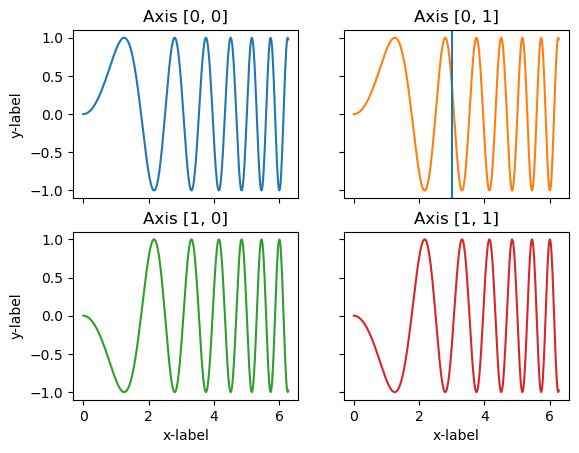

In [224]:
import matplotlib.pyplot as plt
import numpy as np

# Some example data to display
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x, y)
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(x, y, 'tab:orange')
axs[0, 1].axvline(3)
axs[0, 1].set_title('Axis [0, 1]')
axs[1, 0].plot(x, -y, 'tab:green')
axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(x, -y, 'tab:red')
axs[1, 1].set_title('Axis [1, 1]')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

30
